In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Loading Data 

k_bins = {}
z_bins = {}

max_val = float(1.001)
min_val = float(0.999)

for g_val in [max_val, min_val]:
    g_key = f'{float(g_val * 1000) / 1000}'
    for k in range(7):
        k_bins[f'{g_key}_{k}'] = np.loadtxt(f'data/DES_oneXi_newSmoothing_Data/{g_val}kbin{k}.modelvector')

for gnew_val in [max_val, min_val]:
    gnew_key = f'{float(gnew_val * 1000) / 1000}'
    for z in range(4):
        z_bins[f'{gnew_key}_{z}'] = np.loadtxt(f'data/DES_oneXi_newSmoothing_Data/{gnew_key}zbin{z}.modelvector')

In [84]:
# Initialize lists for k and z bins
k_lists = {f'k{i}_list': np.zeros(400) for i in range(7)}
z_lists = {f'z{i}_list': np.zeros(400) for i in range(4)}

denom = max_val - min_val

# Populate k and z lists with calculations
for i in range(400):
    for k in range(7):
        k_lists[f'k{k}_list'][i] = (k_bins[f'1.001_{k}'][i][1] - k_bins[f'0.999_{k}'][i][1]) / denom
    for k in range(4):
        z_lists[f'z{k}_list'][i] = (z_bins[f'1.001_{k}'][i][1] - z_bins[f'0.999_{k}'][i][1]) / denom

# Initialize residuals for k and z bins
resid_z = {f'resid_z{i}': np.zeros((400, 2)) for i in range(4)}
resid_k = {f'resid_k{i}': np.zeros((400, 2)) for i in range(7)}

# Calculate residuals
for i in range(400):
    for j in range(4):
        resid_z[f'resid_z{j}'][i] = [i, (z_bins[f'1.001_{j}'][i][1] - z_bins[f'0.999_{j}'][i][1]) / z_bins[f'0.999_{j}'][i][1]]
    for j in range(7):
        resid_k[f'resid_k{j}'][i] = [i, (k_bins[f'1.001_{j}'][i][1] - k_bins[f'0.999_{j}'][i][1]) / k_bins[f'0.999_{j}'][i][1]]


In [85]:
residuals_list = [resid_k[f'resid_k{i}'] for i in range(7)] + [resid_z[f'resid_z{i}'] for i in range(4)]
#residuals_list = [resid_z[f'resid_z{i}'] for i in range(7)]

In [86]:
derivatives = np.array([*k_lists.values(), *z_lists.values()])

derivatives

array([[ 9.45650e-07,  8.69250e-07,  8.29850e-07, ...,  2.80845e-07,
         4.24385e-07,  5.14315e-07],
       [-5.13955e-06, -3.40705e-06, -1.95820e-06, ...,  8.95910e-07,
         6.90140e-07,  4.42215e-07],
       [ 6.54030e-06,  6.25780e-06,  5.96850e-06, ...,  4.10920e-07,
         2.31510e-07,  1.26645e-07],
       ...,
       [ 1.17245e-06,  9.50800e-07,  7.62400e-07, ...,  7.03350e-07,
         6.04360e-07,  5.09465e-07],
       [ 2.19500e-08,  1.78000e-08,  1.45500e-08, ...,  4.39070e-07,
         3.61755e-07,  2.90285e-07],
       [ 1.12500e-08,  9.50000e-09,  8.05000e-09, ...,  1.32950e-07,
         1.06145e-07,  7.76050e-08]])

In [87]:
def get_full_cov(cov_file):
    print("Getting covariance...")
    full_cov = np.loadtxt(cov_file)
    cov = np.zeros((output_dims, output_dims))
    cov_scenario = full_cov.shape[1]
    for line in full_cov:
        i = int(line[0])
        j = int(line[1])
        if(cov_scenario==3):
            cov_ij = line[2]
        elif(cov_scenario==10):
            cov_g_block  = line[8]
            cov_ng_block = line[9]
            cov_ij = cov_g_block + cov_ng_block
        cov[i,j] = cov_ij
        cov[j,i] = cov_ij
    return cov
#masked_inv_cov = np.linalg.inv(cov[mask][:,mask])

#cov_file = "data/COV2_Y1_mcal_v04.17_3column_rr"

cov_file = "data/cov_unblinded_final.txt" #correct covariance file cooresponding to the data

output_dims = 900

cov = get_full_cov(cov_file)

cov_sub = cov[:400, :400]

inv_cov_sub = np.linalg.inv(cov_sub)

masked_inv_cov = np.linalg.inv(cov)

masked_inv_cov = np.zeros((900, 900))

masked_inv_cov[:400, :400] = inv_cov_sub
masked_inv_cov = masked_inv_cov[:400, :400]

Getting covariance...


In [88]:
num_params = derivatives.shape[0]
fisher_matrix = np.zeros((num_params, num_params))

# Construct the Fisher matrix
for i in range(num_params):
    for j in range(num_params):
        fisher_matrix[i, j] = derivatives[i, :] @ masked_inv_cov @ derivatives[j, :]

print("Fisher Matrix:\n", fisher_matrix)

Fisher Matrix:
 [[ 1.02669279e+02  8.04230514e+00  1.59821261e+01 -3.18246389e+01
   2.87744678e+01 -6.12673116e-01  2.60012148e+01  1.01027610e+02
   4.09534999e+01  1.24719004e+01  1.38566421e+00]
 [ 8.04230514e+00  2.59467865e+02  8.96908127e+01  7.11621314e+01
  -4.60082367e+01 -2.72625054e+01 -9.70706792e+01 -1.48089314e+02
   2.82959450e+01  5.78197814e+01  1.22257979e+01]
 [ 1.59821261e+01  8.96908127e+01  2.42285670e+02  1.55716199e+02
   4.61092922e+01 -4.26311749e+01 -3.48918446e+01  3.64580507e+02
   8.54028860e+01  4.41293029e+01  9.41345785e+00]
 [-3.18246389e+01  7.11621314e+01  1.55716199e+02  3.46462325e+02
   1.31622090e+02  3.33980282e+01 -9.32376720e+01  3.42213700e+02
   7.16186327e+01  5.47711498e+01  1.27365794e+01]
 [ 2.87744678e+01 -4.60082367e+01  4.61092922e+01  1.31622090e+02
   3.41395597e+02  1.05113643e+02 -2.16246203e+01  4.95838895e+02
   1.41240875e+02  5.54206544e+01  9.85656987e+00]
 [-6.12673116e-01 -2.72625054e+01 -4.26311749e+01  3.33980282e+01
   

In [89]:
eigenvalues, eigenvectors = np.linalg.eigh(fisher_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Print the sorted eigenvalues and corresponding eigenvectors
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

# Principal components are the eigenvectors
principal_components = eigenvectors

Eigenvalues:
 [2.26897464e+03 5.41883269e+02 4.72307403e+02 2.96082709e+02
 1.82854819e+02 1.64607672e+02 7.11203014e+01 6.13849784e+01
 3.26459750e+01 4.66029529e+00 5.01858612e-01]
Eigenvectors:
 [[-4.72897047e-02 -6.75928175e-02 -4.99521195e-02  1.73842934e-01
   3.57856530e-01 -2.32135723e-01 -7.68227979e-01  3.99396191e-01
  -1.69740104e-01  4.33793013e-03 -2.82118146e-03]
 [ 5.75033973e-02  5.14966855e-01 -2.09537952e-01  1.94581292e-01
   7.08290580e-02 -6.04880983e-01 -5.25379091e-02 -4.85361688e-01
   1.08349550e-01 -1.67207442e-01 -2.83293508e-02]
 [-1.85393477e-01  3.87309746e-01 -1.60591570e-02  4.27684273e-01
  -2.65763501e-02  7.29197667e-02  3.44089538e-01  3.13091421e-01
  -6.37671243e-01 -5.80976238e-02 -1.13775899e-03]
 [-1.97371851e-01  5.23787846e-01 -1.08151138e-01 -2.63446734e-01
  -4.69524634e-01  4.15792787e-01 -4.50928014e-01 -2.97343215e-02
   1.87101165e-02 -8.72369905e-02 -8.49738003e-03]
 [-2.68867431e-01 -1.23614806e-02 -2.18725970e-01 -5.43577576e-01
   5

In [90]:
#estimation
def chi_square(params):
    csq = 0
    for i in range(4):
        csq += eigenvalues[i] * np.sum(params*eigenvectors[:,i]) ** 2
    return csq

In [91]:
sup_optimal_full = [0.01436,    0.04483578, 0.04161128, 0.05740327, 0.06850502, 0.0655324,
 0.04208513, 0.0719795,  0.13827669, 0.07503881, 0.01437212]
sup_optimal_z = sup_optimal_full[7:]

In [92]:
#The test that wasn't lining up
changed = np.array([0.01,-0.01,0.01,-0.01,0.01,-0.01,0.01,0.01,-0.01,0.01,-0.01])
print(changed)
chi_square(changed)

[ 0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01  0.01 -0.01  0.01 -0.01]


0.3822578715251944

In [93]:
chi_square(sup_optimal_full)

53.931147531540994

In [94]:
alpha = np.array(sup_optimal_full)
#beta model
def beta_chi_square(beta):
    csq = 0
    alphaOne = np.array([0] * 7 + [0.1,0.3,0.5,0.7])
    for i in range(7, 11):
        alphaOne[i] = beta / (0.7 + 0.3 * (1+alphaOne[i])**3)
    delta_alpha = alpha - alphaOne
    for i in range(4):
        csq += eigenvalues[i] * np.sum(delta_alpha*eigenvectors[:,i]) ** 2
    return csq

In [95]:
#minimum beta model
from scipy.optimize import minimize
initial_guess = [0]

result = minimize(beta_chi_square, initial_guess, method='L-BFGS-B')

print("Optimal beta:", result.x)
print("Minimum value of beta_chi_square:", result.fun)

Optimal beta: [0.1478313]
Minimum value of beta_chi_square: 5.540288473792911


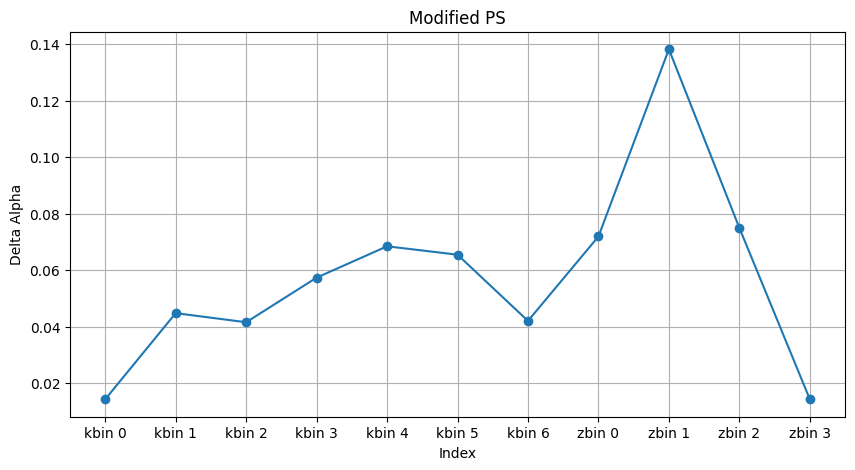

In [96]:
labels = [f'kbin {i}' for i in range(7)] + [f'zbin {i}' for i in range(4)]
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(sup_optimal_full, marker='o')
plt.title('Modified PS')
plt.xlabel('Index')
plt.ylabel('Delta Alpha')
plt.xticks(ticks=range(len(sup_optimal_full)), labels=labels)
plt.grid(True)
# Display the plot
plt.show()

# One more try on optimal min with derivatives only coming from the z (this method only works if I rerun the original optimizer to get optimal over just z, so this is not consistent in what follows):

In [97]:
derivatives = np.array([ *z_lists.values()])

derivatives

array([[5.892985e-05, 5.027165e-05, 4.226595e-05, ..., 4.772400e-07,
        3.847300e-07, 3.130600e-07],
       [1.172450e-06, 9.508000e-07, 7.624000e-07, ..., 7.033500e-07,
        6.043600e-07, 5.094650e-07],
       [2.195000e-08, 1.780000e-08, 1.455000e-08, ..., 4.390700e-07,
        3.617550e-07, 2.902850e-07],
       [1.125000e-08, 9.500000e-09, 8.050000e-09, ..., 1.329500e-07,
        1.061450e-07, 7.760500e-08]])

In [98]:
num_params = derivatives.shape[0]
fisher_matrix = np.zeros((num_params, num_params))

# Construct the Fisher matrix
for i in range(num_params):
    for j in range(num_params):
        fisher_matrix[i, j] = derivatives[i, :] @ masked_inv_cov @ derivatives[j, :]

print("Fisher Matrix:\n", fisher_matrix)

Fisher Matrix:
 [[1898.03735128  206.07796423   34.07282148    5.96394378]
 [ 206.07796423  306.25218785  140.9496853    25.63269382]
 [  34.07282148  140.9496853    82.96682738   16.47991135]
 [   5.96394378   25.63269382   16.47991135    3.97992405]]


In [99]:
eigenvalues, eigenvectors = np.linalg.eigh(fisher_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Print the sorted eigenvalues and corresponding eigenvectors
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

# Principal components are the eigenvectors
principal_components = eigenvectors

Eigenvalues:
 [1.92578693e+03 3.51157648e+02 1.37251603e+01 5.66549954e-01]
Eigenvectors:
 [[-0.99127324 -0.12740413 -0.03370245 -0.00311415]
 [-0.12866995  0.87930971  0.45630414  0.04522187]
 [-0.0282146   0.45111209 -0.85065024 -0.26850694]
 [-0.00503434  0.08414576 -0.25893018  0.96221064]]


In [100]:
alpha = np.array(sup_optimal_z)

def beta_chi_square(beta):
    csq = 0
    alphaOne = np.array([0.1,0.3,0.5,0.7])
    for i in range(4):
        alphaOne[i] = beta / (0.7 + 0.3 * (1+alphaOne[i])**3)
    delta_alpha = alpha - alphaOne
    for i in range(4):
        csq += eigenvalues[i] * np.sum(delta_alpha*eigenvectors[:,i]) ** 2
    return csq

In [101]:
from scipy.optimize import minimize
initial_guess = [0]

result = minimize(beta_chi_square, initial_guess, method='L-BFGS-B')

print("Optimal beta:", result.x)
print("Minimum value of beta_chi_square:", result.fun)

Optimal beta: [0.0994382]
Minimum value of beta_chi_square: 1.6531206871222646
